# Deep learning-based shape correspondence workshop (June 2024)
### Overview:

In this hands-on tutorial we're going to go therough the process of setting up, training and evaluating the results produced by a popular learning-based correspondence method.

For this tutorial we shall use the SHREC'20 dataset of 3D animal shapes: http://robertodyke.com/shrec2020/index2.html

We will be using the "Neuromorph" correspondence model designed by Eisenberger et al. that was described briefly in the talk this morning. Paper: https://arxiv.org/pdf/2106.09431 Original code: https://github.com/facebookresearch/neuromorph

We'll be going through this tutorial step-by-step and please feel free to ask any questions along the way.

---
### Contents
The steps in this notebook are as follows:

0. Install prerequisites and set up the google colab environment
1. Explore the dataset
2. Pre-processing - Supervised vs. unsupervised learning for correspondence models
3. Setting up a learning-based correspondence model (Neuromorph)
4. Training the correspondence model
5. Evaluation - geodesic distance and landmarks
6. Exploration of limitations and possible solutions
---

# How to use Colab 
Colab is a free ML playground from google. It allows you free access to limited resources, including a GPU and some storage space. Even though the limits are quite small: ~50GB disk, 12GB RAM & a T4 GPU, you can do some pretty cool stuff with it. 

__You will need a Google account to sign into it.__

*Important*:

We are going to be training a Convolutional Neural Network (CNN), so we need to get a GPU. To do this, click "Runtime" in the menu across the top of the colab page, then select "Change Runtime Type". From the dropdown, select GPU and click Save. The runtime will then reboot and you should have a GPU. To find out what you got, run the cell below this text.

In [ ]:
## Find out what GPU we got (and make sure we actually have one!)
!nvidia-smi

In [ ]:
## Download all the data and network library! This may take a little while...

## Processed data
try:
    import google.colab
    IN_COLAB = True
    !wget -O /content/data_directory.tar.gz https://www.dropbox.com/scl/fi/hgjapycrcuste048yh6b9/data_directory.tar.gz?rlkey=c3eerq4g2xnf7faw8olkjhmp6&st=bpgzfl0l&dl=0 
    !tar -xzf /content/data_directory.tar.gz -C /content/
    !rm /content/data_directory.tar.gz
except:
    IN_COLAB = False
    !wget -O ./data_directory.tar.gz https://www.dropbox.com/scl/fi/hgjapycrcuste048yh6b9/data_directory.tar.gz?rlkey=c3eerq4g2xnf7faw8olkjhmp6&st=khq2k6i9&dl=0
    !tar -xzf ./data_directory.tar.gz -C ./
    !rm ./data_directory.tar.gz

# network library files and images
!git clone https://github.com/edhendo/test_workshop.git
!cp -r test_workshop/neuromorph_adapted/ .
!rm -r test_workshop/

# pretrained model weights
if IN_COLAB:
    !wget -O /content/ckpt_ep229.pth https://www.dropbox.com/scl/fi/bj2564h5oyyu0c4d9v0l6/ckpt_ep229.pth?rlkey=sktsapnqmn5h8w5ngwur9v0r8&st=ed9apxpf&dl=0
else:
    !wget -O ./ckpt_ep229.pth https://www.dropbox.com/scl/fi/bj2564h5oyyu0c4d9v0l6/ckpt_ep229.pth?rlkey=sktsapnqmn5h8w5ngwur9v0r8&st=ed9apxpf&dl=0

Some imports

In [ ]:
!pip install open3d
!pip install pyvista==0.37.0
!apt install libgl1-mesa-glx xvfb
!pip install trame-vtk
!pip install ipywidgets
!pip install pygeodesic
!pip install torch_geometric
!pip install torch_scatter -f https://data.pyg.org/whl/torch-2.3.0+cu121.html

# Part 1: The dataset (SHREC'20 3D meshes of animals)

To start with let's explore the dataset. In this tutorial we will be looking at the SHREC 2020 dataset containing non-isometric deformations. This dataset consists of the 3D shapes of 14 different animals. The 3D shapes themselves are constructed of triangular meshes. 

Let's first visualise a couple of these 3D animal shapes to get an idea of what we're working with.

In [8]:
# import some libraries
import numpy as np
import open3d as o3d        # open3d is a very powerful python library for 3D shape operations and manipulation

mesh = o3d.io.read_triangle_mesh("data/meshes/camel.obj")
vertices = np.asarray(mesh.vertices)
triangles = np.asarray(mesh.triangles)
print(f"Vertices:    shape: {vertices.shape}")
print(vertices, "\n")
print(f"Triangles:    shape: {triangles.shape}")
print(triangles)

Vertices:    shape: (9766, 3)
[[-0.89642799 -0.191065   -0.017055  ]
 [-0.89735597 -0.18036599 -0.005702  ]
 [-0.89654702 -0.19123299 -0.01181   ]
 ...
 [-0.85088199  0.468263    0.29297301]
 [-0.83170497 -0.396777    0.093855  ]
 [-0.85233998 -0.36082399 -0.39064401]] 

Triangles:    shape: (19528, 3)
[[   0    1    2]
 [   0    3    1]
 [   0    4    3]
 ...
 [1834 9761 1827]
 [1843 9762 1833]
 [1845 9763 1842]]


Using Open3D visualisation:

In [ ]:
mesh = o3d.io.read_triangle_mesh("data/meshes/camel.obj")
vertices = np.asarray(mesh.vertices)
vertices = vertices[:, [0,2,1]] 
mesh.vertices = o3d.utility.Vector3dVector(vertices)
o3d.visualization.draw_plotly([mesh])

Let's use a dedicated package built for 3D visualisation

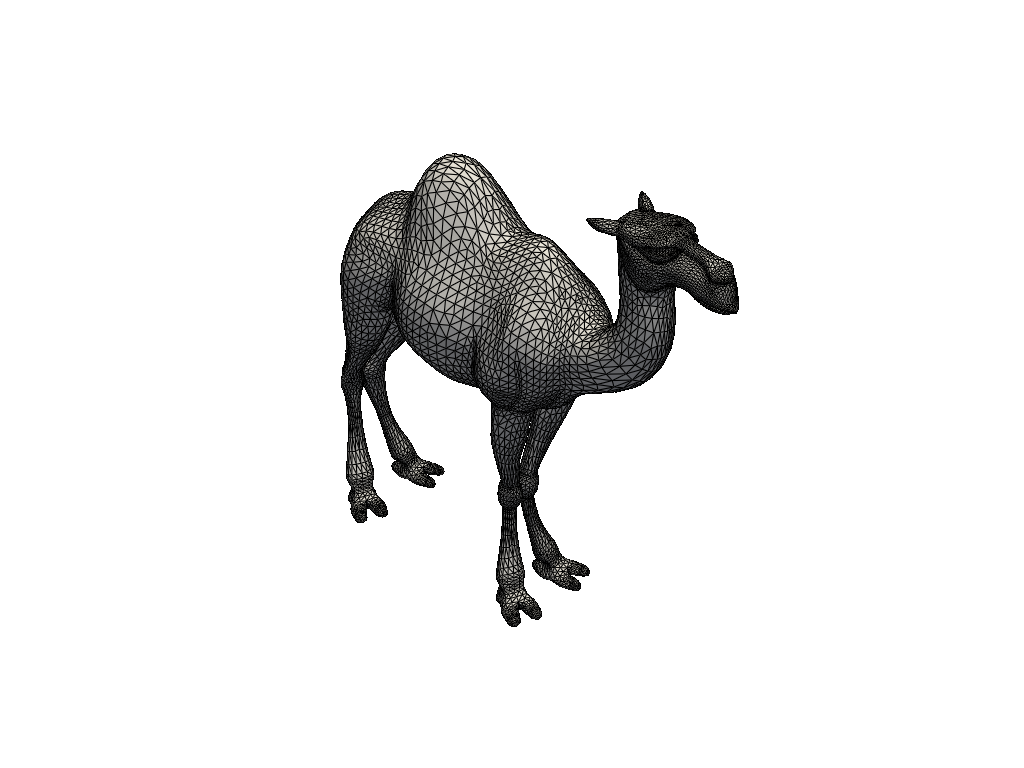

In [13]:
import pyvista              # pyvista the the library we will use to visualise the 3D models
pyvista.start_xvfb()        # virtual frame buffer necessary for colab and notebooks (linux only - remove if running locally on a different OS)

# helper function to convert to pyvista data type
def pyvistarise(verts, triangles):
    return pyvista.PolyData(verts, np.insert(triangles, 0, 3, axis=1), deep=True, n_faces=len(triangles))

mesh = o3d.io.read_triangle_mesh("data/meshes/camel.obj")
verts = np.asarray(mesh.vertices)[:, [0,2,1]]
triangles = np.asarray(mesh.triangles)
pyv_mesh = pyvistarise(verts, triangles)
pyvista.global_theme.background = 'white'
plotter = pyvista.Plotter(notebook=True)
plotter.add_mesh(pyv_mesh, show_edges=True)
plotter.show(jupyter_backend="static")

Let's visualise the some of the other models available in this dataset:

Make sure to look at the bear! What's different about this one?

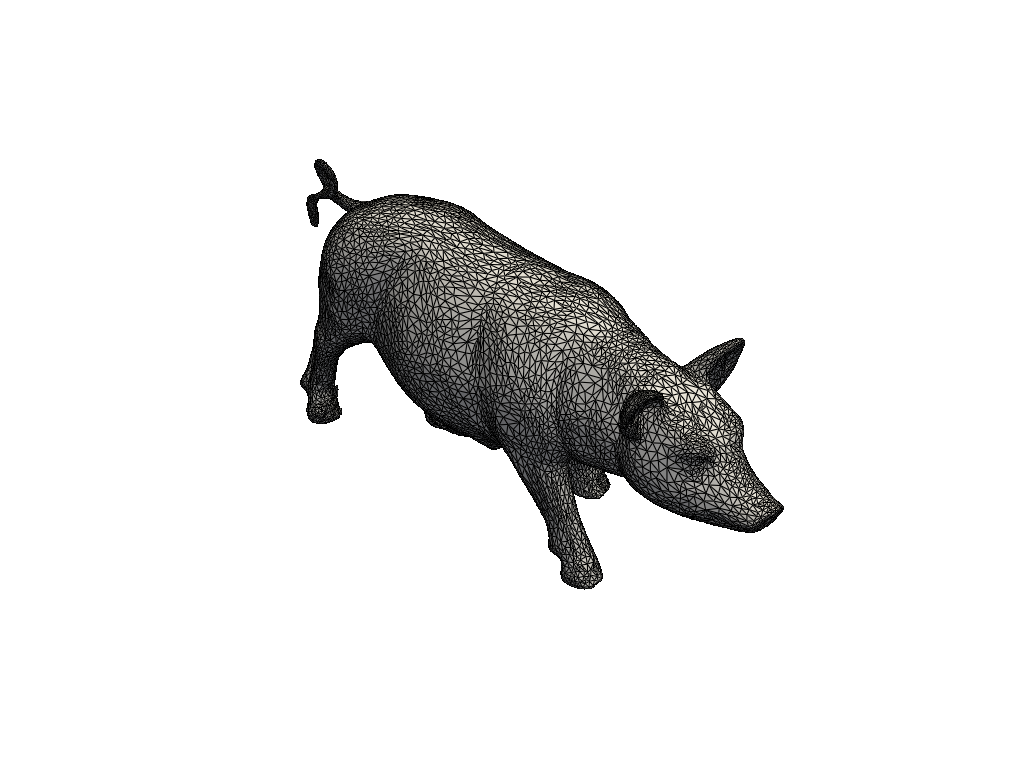

In [32]:
# choice of: ["bear", "bison", "cow", "camel", "dog", "elephant", "giraffe", "hippo", "leopard", "pig", "rhino"] 
animal = "pig"
mesh = o3d.io.read_triangle_mesh(f"data/meshes/{animal}.obj")
verts = np.asarray(mesh.vertices)[:, [0,2,1]]
triangles = np.asarray(mesh.triangles)
pyv_mesh = pyvistarise(verts, triangles)
pyvista.global_theme.background = 'white'
plotter = pyvista.Plotter(notebook=True)
plotter.add_mesh(pyv_mesh, show_edges=True)
plotter.show(jupyter_backend="static")

## Side note: reducing the size of large meshes
Sometimes it's useful to reduce the size/resolution of the 3D models (e.g. for computational requirements/efficiency). 

Open3D has good tools for this, you can play with the examples below to see how these work. How does a model look if you reduce the number of triangles to 10,000, 1,000, 100?

Each of the shape models in the dataset we're using today has a maximum of 20,000 which is reasonable for this task.

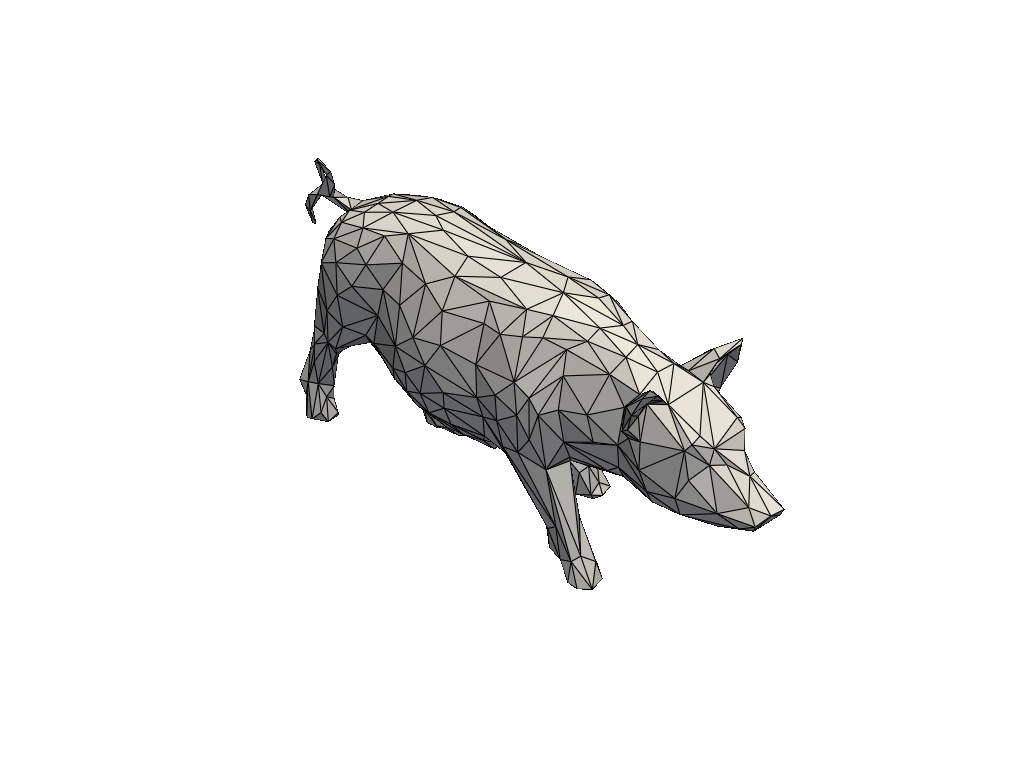

In [24]:
animal = "pig"
mesh = o3d.io.read_triangle_mesh(f"data/meshes/{animal}.obj")

mesh = mesh.simplify_quadric_decimation(target_number_of_triangles=1000)
#mesh = mesh.filter_smooth_taubin(number_of_iterations=10)             # additionally smoothing can be useful when reducing the resolution of large meshes

verts = np.asarray(mesh.vertices)[:, [0,2,1]]
triangles = np.asarray(mesh.triangles)
pyv_mesh = pyvistarise(verts, triangles)
pyvista.global_theme.background = 'white'
plotter = pyvista.Plotter(notebook=True)
plotter.add_mesh(pyv_mesh, show_edges=True)
plotter.show(jupyter_backend="static")

# Part 2: Pre-processing - Supervised vs. un-supervised learning for correspondence models

- What is the difference between supervised and un-supervised learning?
- For learning-based correspondence models unsupervised learning tends to be most regularly used.
- What could be the issue of using supervised learning when training a correspondence model?

We need some "metric of matching" to drive the learning process and train the model to make reasonable correspondence predictions.

To create this metric we're going to use geodesic distances or paths. The image below shows geodesic distances from the tigers mouth in different colours.

![image of geodesic tiger](images/tiger_geodesic_dists.jpg)

Let's plot a geodesic path on one of shapes:

In [ ]:
import pygeodesic.geodesic as geodesic      # import package to calculate geodesic distances

mesh = o3d.io.read_triangle_mesh("data/meshes/camel.obj")
vertices = np.asarray(mesh.vertices)[:, [0,2,1]] # just reordering x, y, z for visualisation
triangles = np.asarray(mesh.triangles)
geo_alg = geodesic.PyGeodesicAlgorithmExact(vertices, triangles)
source_index = 4000
target_index = 1500
distances, _ = geo_alg.geodesicDistances(np.array([source_index]))
distance, path = geo_alg.geodesicDistance(source_index, target_index)

pyv_mesh = pyvistarise(vertices, triangles)
pyvista.global_theme.background = 'white'
plotter = pyvista.Plotter(notebook=True)

sargs = dict(title_font_size=28, label_font_size=26, shadow=False, n_labels=5, italic=False, fmt="%.1f", font_family="arial", color='black', bold=False, title="Geodesic distance")
plotter.add_mesh(pyv_mesh, show_edges=False, scalars=distances, cmap="YlOrRd", scalar_bar_args=sargs)
plotter.add_lines(path, color='b', width=5)
plotter.show(jupyter_backend="static")

How can we use these to learn correspondences between different shapes?

- Formulate a loss function based on conservation of geodesic distances:
- i.e. compare distance between two points on mesh X and their allocated corresponding points on mesh Y
- minimise the difference between the two distances

![image of s](images/geodesic_loss_component.png)

D_x and D_y are matrices of the geodesic distances (see example below) and Pi is the correspondence assignment
 
For full details please see Eisenberger et al. (https://arxiv.org/pdf/2106.09431)

In [ ]:
# short example plotting a geodesic matrix for a single shape
import matplotlib.pyplot as plt
camel_geodesic_distances = np.load("data/geodesic_distances/camel.npy")
plt.imshow(camel_geodesic_distances, cmap="magma")
plt.title("Geodesic distances")
plt.xlabel("Index i")
plt.ylabel("Index j")
plt.show()

## Pre-processing step

To start with we need to compute these geodesic matrices for each shape!

N.B. This step is MASSIVELY computationally expensive and takes a few hours with a good CPU - fortunately the matrices have already been computed and are located in "./data/geodesic_distances/" 

In [ ]:
import pygeodesic.geodesic as geodesic
from neuromorph_adapted.utils.utils import getFiles
from os.path import join
from tqdm import tqdm

def compute_geodesic_distances(vertices, triangles):    # function to compute geodesic distances between all pairs of vertices
    n_vertices = vertices.shape[0]
    geo_alg = geodesic.PyGeodesicAlgorithmExact(vertices, triangles)
    D = np.zeros((n_vertices, n_vertices), dtype=np.float16)
    for source_index in tqdm(range(n_vertices)):
        D[source_index], _ = geo_alg.geodesicDistances(np.array([source_index]))
    try:
        assert (D - D.T < 1e-4).all()
    except AssertionError:
        print(f"Assertion error - max value: {np.abs(D - D.T).max()}")
        # If nan -> It's likely the mesh is not a single connected component -> run some connected component analysis
        return None
    return D

data_folder = "data/meshes"
output_folder = "data/geodesic_distances"

fnames = getFiles(data_folder)
fname = fnames[0]
mesh = o3d.io.read_triangle_mesh(join(data_folder, fname))
vertices = np.asarray(mesh.vertices)
triangles = np.asarray(mesh.triangles)
D = compute_geodesic_distances(vertices, triangles)
if D is not None:
    print(f"Computed geodesic distances for {fname}")
else:
    print(f"Failed to compute geodesic distances for {fname}")

### IMPORTANT!
Need to restart the virtual frame buffer after KeyboardInterrupt

In [ ]:
pyvista.start_xvfb()

Calculating full matrices takes way too long! So they've been computed ahead of time and are located in "./data/geodesic_distances/"

Cool what's next!

### Registration loss and regularisation

A loss function based on geodesic distances isn't enough - particularly when the shapes are non-isometric!

![non-isometric example](images/non_isometric_example.png)

To overcome this Eisenberger et al. introduce use a model sucture which additionally deforms and warps the shapes to overlap and integrate aregistration loss based on chamfer matching.

It is possible to attain perfect registration by deforming a shape wildly: (blue: target, red: source)

LEFT: Before deformation --- CENTRE: deformation with regularisation --- RIGHT: deformation without regularisation

![mad fish registration](images/2d_chamfer_matching_registration_example.png)

Additionally need a way of regularising the allowed deformations
- add a local distortion metric to minimise distortion of triangles through interpolation.
- for details see Eisenberger et al. (https://arxiv.org/pdf/2106.09431)

# Part 3: Setting up a learning-based correspondence model (Neuromorph)

# TODO

![Neuromorph architecture](images/neuromorph_model.png)

First let's set up the correspondence model and make some predictions with a randomly initialised network

In [ ]:
# import relevant portions of the correspondence model library
from neuromorph_adapted.model.interpolation_net import *
from neuromorph_adapted.utils.arap import ArapInterpolationEnergy
from neuromorph_adapted.data.data import *
from neuromorph_adapted.utils.utils import ParametersBase
import pickle

# load the model and some mesh data
data_folder = "data/meshes"
os.makedirs("results", exist_ok=True)
source_mesh = o3d.io.read_triangle_mesh(join(data_folder, "bison.obj"))
target_mesh = o3d.io.read_triangle_mesh(join(data_folder, "cow.obj"))


# This class is used to set particular hyper-parameters of the correspondence model, we'll add a few more in the next step
class NetworkParameters(ParametersBase):
    def __init__(self):
        super().__init__()
        self.num_timesteps = 0
        self.hidden_dim = 64

def run_correpondence_inference(model, source_mesh, target_mesh):
    
    def convert_to_batch(mesh):
        verts = torch.tensor(np.asarray(mesh.vertices).astype(np.float32))
        shift = torch.mean(verts, dim=0)
        verts = verts - shift
        #verts = verts / torch.max(torch.abs(verts) # some of the shapes in this dataset are very different sizes and it helps to normalise the physical size
        triangles = torch.tensor(np.asarray(mesh.triangles))
        return {"verts": verts, "triangles": triangles, "shift": shift}
    
    # convert raw mesh data to batch dictionary for the model (just for consistency later)
    source_data = convert_to_batch(source_mesh)
    target_data = convert_to_batch(target_mesh)

    with torch.no_grad():
        source_shape = batch_to_shape(source_data)
        target_shape = batch_to_shape(target_data)

        point_pred = model.get_pred(source_shape, target_shape)     # run inference between the two shapes
        point_pred = point_pred.cpu().numpy()                       

        corr_out = model.match(source_shape, target_shape)          # obtain correspondence prediction (logits / probabilities)
        assignment = corr_out.argmax(dim=1).cpu().numpy()           # determine correspondence mapping by finding the maximum probability for each vertex (fairly crude)
        assignmentinv = corr_out.argmax(dim=0).cpu().numpy()        # similarly find the reverse mapping

        source_verts = source_shape.verts.cpu().numpy()
        target_verts = target_shape.verts.cpu().numpy()
        triangles_x = source_shape.triangles.cpu().numpy()
        triangles_y = target_shape.triangles.cpu().numpy()

        result = {}
        result["assignment"] = assignment
        result["assignmentinv"] = assignmentinv
        result["X"] = {"verts": source_verts, "triangles": triangles_x, "shift": source_data["shift"]}
        result["Y"] = {"verts": target_verts, "triangles": triangles_y, "shift": target_data["shift"]}
        result["interpolation_verts"] = point_pred
        result["raw_correspondence_predictions"] = corr_out.cpu().numpy()
        
        return result

# Deformation model based on the "As-rigid-as-possible" energy formulation (Olga Sorkine and Marc Alexa, 2007)
interpolation_energy = ArapInterpolationEnergy()
# Create full correspondence model (random initialisation)
correspondence_model = InterpolationModGeoEC(interpolation_energy, NetworkParameters()).to(device)

result = run_correpondence_inference(correspondence_model, source_mesh, target_mesh)
# save the result
with open("results/random_init_correspondence_result.pkl", "wb") as f:
    pickle.dump(result, f)

# display outputs (visualise)
source_verts = result["X"]["verts"][:, [0,2,1]] # just reordering x, y, z for visualisation
target_verts = result["Y"]["verts"][:, [0,2,1]] # just reordering x, y, z for visualisation
triangles_x = result["X"]["triangles"]
triangles_y = result["Y"]["triangles"]

# offset the target mesh for the visualsation
target_verts = target_verts + np.array([1,0,0])

pyvista.global_theme.background = 'white'
plotter = pyvista.Plotter(notebook=True)

# Forward assignment
# set colours on target mesh corresponding with xyz position
target_colours = target_verts - np.min(target_verts, axis=0)
target_colours = target_colours / np.max(target_colours, axis=0)
target_colours = np.concatenate([target_colours, np.ones((len(target_colours), 1))], axis=1)
# set colours on source mesh according to the predicted correspondence assignment
assignment = result["assignment"]
source_colours = target_colours[assignment]

# add points
plotter.add_points(target_verts, opacity=1., point_size=10, render_points_as_spheres=True, scalars=target_colours, rgb=True)
plotter.add_points(source_verts, opacity=1., point_size=10, render_points_as_spheres=True, scalars=source_colours, rgb=True)
plotter.show(jupyter_backend="static")

Somewhat interestingly, an untrained model with randomly initialised weights can produce plausible results.

 - Attaiki et al. showed a neural network itself can act as a powerful prior for shape correspondence problems.
 - Produce pointwise features that capture local geometry and lead to well-structured maps between shapes.
 - https://arxiv.org/abs/2301.05839

# Part 4: Training the correspondence model

Now let's actually train the network on a small subset of data to see if the correspondence results improve!

To start with we'll train for a single epoch on all animals apart from our testing pair, the cow and the bison. 

This yields 9^2 = 81 training pairs.

In [ ]:
# training code
from neuromorph_adapted.model.interpolation_net import *
from neuromorph_adapted.utils.arap import ArapInterpolationEnergy
from neuromorph_adapted.data.data import *
from neuromorph_adapted.utils.utils import ParametersBase, k_fold_split_train_val_test, getFiles

class NetworkParameters(ParametersBase):
    def __init__(self):
        super().__init__()
        self.lr = 1e-4
        self.num_it = 1
        self.batch_size = 16
        self.num_timesteps = 0
        self.hidden_dim = 64
        # the lambda values here control the weights of the three loss functions we described previously
        self.lambd = 1          # registration loss
        self.lambd_geo = 100    # geodesic distance conservation loss
        self.lambd_arap = 1     # regularisation

        self.log_freq = 1
        self.val_freq = 1

        self.log = True

def create_correspondence_model(dataset, dataset_val=None, time_stamp=None, description="", param=NetworkParameters(), folder_weights_load=None):
    if time_stamp is None:
        time_stamp = get_timestr()

    # Deformation model based on the "As-rigid-as-possible" energy formulation (Olga Sorkine and Marc Alexa, 2007)
    interpol_energy = ArapInterpolationEnergy()

    # Correspondence model
    interpol_module = InterpolationModGeoEC(interpol_energy, param).to(device)

    
    preproc_mods = []
    preproc_mods.append(PreprocessRotateSame(dataset.axis))
    
    settings_module = timestep_settings(increase_thresh=3)
    
    train_loader = torch.utils.data.DataLoader(dataset, shuffle=True)
    if dataset_val is not None:
        val_loader = torch.utils.data.DataLoader(dataset_val, shuffle=False)
    else:
        val_loader = None

    interpol = InterpolNet(interpol_module, train_loader, val_loader=val_loader, time_stamp=time_stamp, description=description, preproc_mods=preproc_mods, settings_module=settings_module)

    if folder_weights_load is not None:
        interpol.load_self(save_path(folder_str=folder_weights_load))

    return interpol

data_folder = "./data/"

# # determine which meshes to use - this code would be useful if we were performing a proper cross-validaion
# all_fnames = getFiles(join(data_folder, "meshes"))
# train_inds, val_inds, _ = k_fold_split_train_val_test(dataset_size=len(all_fnames), fold_num=1, seed=1004)
# train_fnames = [all_fnames[i].replace('.obj','') for i in train_inds]
# val_fnames = [all_fnames[i].replace('.obj','') for i in val_inds]

train_fnames = ["bear", "camel", "dog", "elephant", "giraffe", "hippo", "leopard", "pig", "rhino"] 
#val_fnames = ["bison", "cow"]

dataset_train = general_dataset(data_folder, fnames=train_fnames, load_dist_mat=True)
#dataset_val = general_dataset(data_folder, fnames=val_fnames, load_dist_mat=True)

correspondence_model = create_correspondence_model(dataset_train, dataset_val=None, description=f"test1")
correspondence_model.train()


### Using the trained correspondence model

Now let's retry inference with the model that has been trained for a single epoch

In [ ]:
# load the model and some mesh data
data_folder = "data/meshes"
source_mesh = o3d.io.read_triangle_mesh(join(data_folder, "bison.obj"))
target_mesh = o3d.io.read_triangle_mesh(join(data_folder, "cow.obj"))

# inference
result = run_correpondence_inference(correspondence_model.interp_module, source_mesh, target_mesh)

# display outputs (visualise)
source_verts = result["X"]["verts"][:, [0,2,1]] # just reordering x, y, z for visualisation
target_verts = result["Y"]["verts"][:, [0,2,1]] # just reordering x, y, z for visualisation
triangles_x = result["X"]["triangles"]
triangles_y = result["Y"]["triangles"]

# offset
target_verts = target_verts + np.array([1,0,0])

pyvista.global_theme.background = 'white'
plotter = pyvista.Plotter(notebook=True)

# Forward assignment
# set colours on target mesh corresponding with xyz position
target_colours = target_verts - np.min(target_verts, axis=0)
target_colours = target_colours / np.max(target_colours, axis=0)
target_colours = np.concatenate([target_colours, np.ones((len(target_colours), 1))], axis=1)
# set colours on source mesh according to the predicted correspondence assignment
assignment = result["assignment"]
source_colours = target_colours[assignment]

# add points
plotter.add_points(target_verts, opacity=1., point_size=10, render_points_as_spheres=True, scalars=target_colours, rgb=True)
plotter.add_points(source_verts, opacity=1., point_size=10, render_points_as_spheres=True, scalars=source_colours, rgb=True)
plotter.show(jupyter_backend="static")

In a single epoch and with such a small dataset it's unlikely that the model will get too much better unfortunately.

### Using a pre-trained model

Instead try loading the weights from a model that has been trained on the same dataset but for hundreds of epochs:

In [ ]:
from neuromorph_adapted.model.interpolation_net import *
from neuromorph_adapted.utils.arap import ArapInterpolationEnergy
from neuromorph_adapted.data.data import *
from neuromorph_adapted.utils.utils import ParametersBase

class NetworkParameters(ParametersBase):
    def __init__(self):
        super().__init__()
        self.lr = 1e-4
        self.num_it = 1
        self.batch_size = 16
        self.num_timesteps = 0
        self.hidden_dim = 128
        self.lambd = 1
        self.lambd_geo = 100
        self.lambd_arap = 1

        self.log_freq = 1
        self.val_freq = 1

        self.log = True

interpol_energy = ArapInterpolationEnergy()
correspondence_model = InterpolationModGeoEC(interpol_energy, param=NetworkParameters()).to(device)
correspondence_model.load_self("./", num_epoch=229)

# load the model and some mesh data
source_mesh = o3d.io.read_triangle_mesh("data/meshes/bison.obj")
target_mesh = o3d.io.read_triangle_mesh("data/meshes/cow.obj")

# inference
result = run_correpondence_inference(correspondence_model, source_mesh, target_mesh)
os.makedirs("results", exist_ok=True)
with open("results/trained_correspondence_result.pkl", "wb") as f:
    pickle.dump(result, f)

# display outputs (visualise)
source_verts = result["X"]["verts"][:, [0,2,1]] # just reordering x, y, z for visualisation
target_verts = result["Y"]["verts"][:, [0,2,1]] # just reordering x, y, z for visualisation
triangles_x = result["X"]["triangles"]
triangles_y = result["Y"]["triangles"]

# offset the target shape for the visualisation
target_verts = target_verts + np.array([1,0,0])

pyvista.global_theme.background = 'white'
plotter = pyvista.Plotter(notebook=True)

# Forward assignment
# set colours on target mesh corresponding with xyz position
target_colours = target_verts - np.min(target_verts, axis=0)
target_colours = target_colours / np.max(target_colours, axis=0)
target_colours = np.concatenate([target_colours, np.ones((len(target_colours), 1))], axis=1)
# set colours on source mesh according to the predicted correspondence assignment
assignment = result["assignment"]
source_colours = target_colours[assignment]

# add points
plotter.add_points(target_verts, opacity=1., point_size=10, render_points_as_spheres=True, scalars=target_colours, rgb=True)
plotter.add_points(source_verts, opacity=1., point_size=10, render_points_as_spheres=True, scalars=source_colours, rgb=True)
plotter.show(jupyter_backend="static")

# Part 5: Numerical evaluation

Creating pretty picture like this is all well and good but we also eed some more concrete evaluation measures to be able to tell if the model is doing well or not and to compare different model hyperparameters or architectures!

### To create some evaluation metrics we're going to use some manually annotated landmarks and the geodesic distances we computed before.

To start with let's look at these landmarks.

In [ ]:
import scipy.io as sio

# display outputs (visualise)
source_verts = result["X"]["verts"][:, [0,2,1]] # just reordering x, y, z for visualisation
target_verts = result["Y"]["verts"][:, [0,2,1]] # just reordering x, y, z for visualisation
triangles_x = result["X"]["triangles"]
triangles_y = result["Y"]["triangles"]

# offset
target_verts = target_verts + np.array([1,0,0])

pyvista.global_theme.background = 'white'
plotter = pyvista.Plotter(notebook=True)

# Forward assignment
# set colours on target mesh corresponding with xyz position
target_colours = target_verts - np.min(target_verts, axis=0)
target_colours = target_colours / np.max(target_colours, axis=0)
target_colours = np.concatenate([target_colours, np.ones((len(target_colours), 1))], axis=1)
# set colours on source mesh according to the predicted correspondence assignment
assignment = result["assignment"]
source_colours = target_colours[assignment]

# add points
plotter.add_points(target_verts, opacity=1., point_size=10, render_points_as_spheres=True, scalars=target_colours, rgb=True)
plotter.add_points(source_verts, opacity=1., point_size=10, render_points_as_spheres=True, scalars=source_colours, rgb=True)

bison_landmark_indices = sio.loadmat("data/ground_truth_landmarks/bison.mat")
cow_landmark_indices = sio.loadmat("data/ground_truth_landmarks/cow.mat")
source_landmark_indices = {k: v for k, v in zip(list(bison_landmark_indices["points"].flatten()), list(bison_landmark_indices["centroids"]))}
target_landmark_indices = {k: v for k, v in zip(list(cow_landmark_indices["points"].flatten()), list(cow_landmark_indices["centroids"]))}
correspondence_lookup = {k: v for k, v in enumerate(assignment)}
common_landmarks = list(set(source_landmark_indices.keys()) & set(target_landmark_indices.keys()))

s_l = (np.array(list(source_landmark_indices.values())) - result["X"]["shift"].numpy())[:, [0,2,1]]
t_l = (np.array(list(target_landmark_indices.values())) - result["Y"]["shift"].numpy())[:, [0,2,1]] + np.array([1,0,0])
plotter.add_points(s_l, opacity=1., point_size=20, render_points_as_spheres=True, color='r')
plotter.add_points(t_l, opacity=1., point_size=20, render_points_as_spheres=True, color='r')

plotter.show(jupyter_backend="static")

### Creating evaluation measures

Let's evaluate the correspondence model before and after training (and compare this to randomly assigned correspondences)

Landmark error:

![landmark error](images/landmark_error.png)

In [ ]:
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 18})

## landmark based error
# 1. Lookup the nearest vertex to each landmark and find the corresponding point in the other shape
# 2. Compute the (geodesic) distance between this point and the true nearest vertex to the landmark
def landmark_errors(source_landmark_vertices, target_landmark_vertices, assignment, target_geodesic_dists, target_area):
    correspondence_lookup = {k: v for k, v in enumerate(assignment)}
    common_landmark_indices = list(set(source_landmark_vertices.keys()) & set(target_landmark_vertices.keys()))
    errors = []
    for landmark_index in common_landmark_indices:
        source_landmark = source_landmark_vertices[landmark_index]
        target_landmark = target_landmark_vertices[landmark_index]
        target_landmark_prime = correspondence_lookup[source_landmark]
        error = (1 / np.sqrt(target_area)) * target_geodesic_dists[target_landmark, target_landmark_prime]
        errors.append(error)
    return errors

def get_nearest_vertices_to_landmarks(landmarks, vertices):
    kdtree = KDTree(vertices)
    nearest_vertices = {}
    for landmark_index, landmark in landmarks.items():
        nearest_vertices[landmark_index] = kdtree.query(landmark)[1]
    return nearest_vertices

# Geodesic distance normalised by the square root area of the mesh
def get_geodesic_error(geodesic_dists_x, geodesic_dists_y, assignment, area_y, n_sample=10000):
    geodesic_dists_x_prime = geodesic_dists_y[assignment]
    geodesic_dists_x_prime = geodesic_dists_x_prime[:, assignment]
    error = np.abs(geodesic_dists_x - geodesic_dists_x_prime)

    # errors normalised by the square root area of the mesh
    geodesic_error = (1 / np.sqrt(area_y)) * error
    # sample n_sample points
    geodesic_error = geodesic_error.reshape(-1)
    geodesic_error_sample = np.random.choice(geodesic_error, n_sample, replace=False)
    return geodesic_error_sample

# load evaluation datasets
bison_landmarks = sio.loadmat("data/ground_truth_landmarks/bison.mat")
cow_landmarks = sio.loadmat("data/ground_truth_landmarks/cow.mat")
bison_vertices = np.asarray(o3d.io.read_triangle_mesh(join(data_folder, "bison.obj")).vertices)
cow_vertices = np.asarray(o3d.io.read_triangle_mesh(join(data_folder, "cow.obj")).vertices)
cow_geodesic_dists = np.load("data/geodesic_distances/cow.npy")
bison_geodesic_dists = np.load("data/geodesic_distances/bison.npy")
cow_area = target_mesh.get_surface_area()

bison_landmarks = {k: v for k, v in zip(list(bison_landmarks["points"].flatten()), list(bison_landmarks["centroids"]))}
cow_landmarks = {k: v for k, v in zip(list(cow_landmarks["points"].flatten()), list(cow_landmarks["centroids"]))}
bison_landmark_vertices = get_nearest_vertices_to_landmarks(bison_landmarks, bison_vertices)
cow_landmark_vertices = get_nearest_vertices_to_landmarks(cow_landmarks, cow_vertices)

# load the resulting correspondences from the randomly initialised model
with open("results/random_init_correspondence_result.pkl", "rb") as f:
    result = pickle.load(f)
# compute the errors
random_init_errors = landmark_errors(bison_landmark_vertices, cow_landmark_vertices, result["assignment"], cow_geodesic_dists, cow_area)
random_init_geodesic_error = get_geodesic_error(bison_geodesic_dists, cow_geodesic_dists, result["assignment"], cow_area)

# load the resulting correspondences from the trained model
with open("results/trained_correspondence_result.pkl", "rb") as f:
    result = pickle.load(f)
# compute the errors
trained_errors = landmark_errors(bison_landmark_vertices, cow_landmark_vertices, result["assignment"], cow_geodesic_dists, cow_area)
trained_geodesic_error = get_geodesic_error(bison_geodesic_dists, cow_geodesic_dists, result["assignment"], cow_area)

# for fun - generate error metrics from randomly assigned correspondences
random_assignment = np.random.choice(len(cow_vertices), size=len(bison_vertices))
no_model_errors = landmark_errors(bison_landmark_vertices, cow_landmark_vertices, random_assignment, cow_geodesic_dists, cow_area)
no_model_geodesic_error = get_geodesic_error(bison_geodesic_dists, cow_geodesic_dists, random_assignment, cow_area)

## Quick plotting of the errors
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(14,6))

# violin plots for the ground truth landmark errors
violinplots = ax0.violinplot([no_model_errors, random_init_errors, trained_errors], positions=[1, 1.6, 2.2], showmeans=True,)
ax0.set_xticks([1, 1.6, 2.2])
ax0.set_xticklabels(["No model", "Random\ninitialisation", "Trained model"])
ax0.set_ylabel("Normalised landmark error")
ax0.set_ylim(0)
colours = ['red', 'blue', 'green']
for i, plot_body in enumerate(violinplots['bodies']):
    plot_body.set_facecolor(colours[i])
    plot_body.set_edgecolor('black')
    plot_body.set_alpha(1)
for line in ['cbars','cmins','cmaxes']:
    violinplots[line].set_color('black')
    violinplots[line].set_linewidth(2)
violinplots['cmeans'].set_linestyle('--')
violinplots['cmeans'].set_color('white')
violinplots['cmeans'].set_linewidth(2)

# cumulative distribution of the geodesic errors
ax1.plot(np.sort(no_model_geodesic_error), np.linspace(0, 100, len(no_model_geodesic_error)), c=colours[0], label="No model")
ax1.plot(np.sort(random_init_geodesic_error), np.linspace(0, 100, len(random_init_geodesic_error)), c=colours[1], label="Random init")
ax1.plot(np.sort(trained_geodesic_error), np.linspace(0, 100, len(trained_geodesic_error)), c=colours[2], label="Trained")

ax1.set_xlabel("Geodesic error")
ax1.set_ylabel(r"% of matches")
ax1.set_ylim(0, 100)
ax1.set_xlim(0)
ax1.legend(loc="lower right")
plt.show()

# Part 6: Limitations and potential solutions

While this method is pretty good and works well in some cases, the are others for which it is particularly poor, espcially if there are large differences in the morphology of the two shapes.

In [ ]:
# example of distinct morphological change
source_mesh = o3d.io.read_triangle_mesh("data/meshes/giraffe.obj")
target_mesh = o3d.io.read_triangle_mesh("data/meshes/elephant.obj")

result = run_correpondence_inference(correspondence_model, source_mesh, target_mesh)

source_verts = result["X"]["verts"][:, [0,2,1]] # just reordering x, y, z for visualisation
target_verts = result["Y"]["verts"][:, [0,2,1]] # just reordering x, y, z for visualisation
triangles_x = result["X"]["triangles"]
triangles_y = result["Y"]["triangles"]
target_verts = target_verts + np.array([2.5,0,0])

plotter = pyvista.Plotter(notebook=True)
# Forward assignment - set colours on target mesh corresponding with xyz position
target_colours = target_verts - np.min(target_verts, axis=0)
target_colours = target_colours / np.max(target_colours, axis=0)
target_colours = np.concatenate([target_colours, np.ones((len(target_colours), 1))], axis=1)
# set colours on source mesh according to the predicted correspondence assignment
assignment = result["assignment"]
source_colours = target_colours[assignment]

plotter.add_points(target_verts, opacity=1., point_size=10, render_points_as_spheres=True, scalars=target_colours, rgb=True)
plotter.add_points(source_verts, opacity=1., point_size=10, render_points_as_spheres=True, scalars=source_colours, rgb=True)
plotter.show(jupyter_backend="static")

## Dataset size

How about training the model on a much larger dataset! The original Neuromorph model was trained using the FAUST dataset (300 scans of people in different poses). 

![image of s](images/FAUST_dataset_banner.png)

## Network modifications

 - Enable the network to make null correspondence predictions (Hard!)
 - Use a more complex algorithm to derive smooth, constrained assignments from the predicted correspondence probabilities (Sinkhorn algorithm)
 - Use lower quality correspondence predictions as supervision examples in a two stage approach:

 ![NCP image](images/Neural_correspondence_prior.png)

 Attaiki and Ovsjanikov 2023, NCP: Neural Correspondence Prior for Effective Unsupervised Shape Matching: https://arxiv.org/abs/2301.05839 

## Modification for use with medical images/shapes

Application to radiotherapy: able to leverage extra information - the associated medical imaging (CT scans)

Doing so allowed the model more context to help identify real corresponding anatomy.

# TODO add image

